# Response Surface Methodology

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from numpy.polynomial import Polynomial
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

from rsm import (
    boxplot,
    design_ccd,
    markout_profit,
    markout_profit_2D,
    run_experiment,
    run_experiment_2D,
)

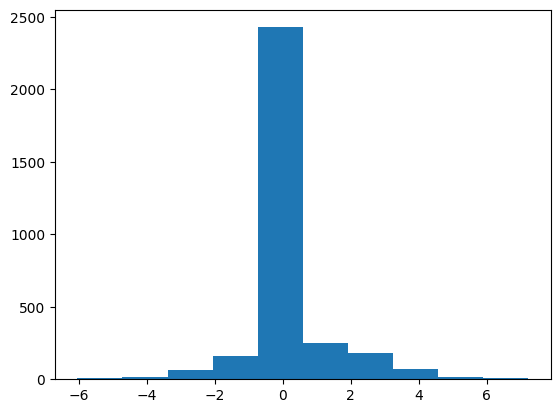

In [2]:
np.random.seed(17)
data = [markout_profit(threshold=1) for _ in range(3200)]
plt.hist(data);

In [3]:
np.mean(data), np.std(data)

(0.20921999649715084, 1.163925290620134)

In [4]:
np.random.seed(17)
thresholds = np.array([0.5, 1.0, 1.5])
aggregate_measurements, standard_errors = run_experiment(15000, thresholds)
aggregate_measurements, standard_errors

([0.09848496576216006, 0.1711214205711533, 0.13699263220703944],
 [0.013267765976681866, 0.00957041724519083, 0.006796544642991194])

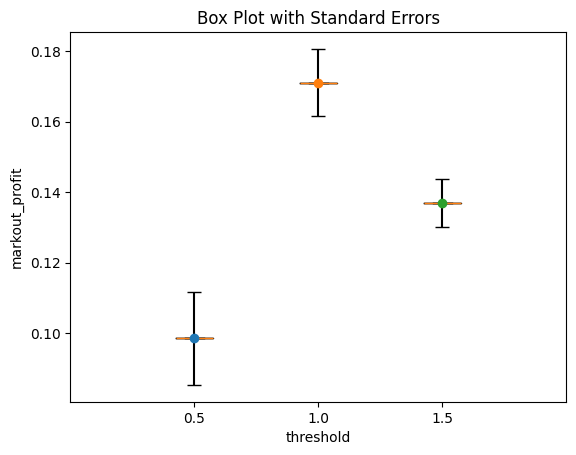

In [5]:
# For boxplot, every group should be an array of measurements,
# that is why we reshape the 1d array of aggregate measurements.
boxplot(np.array(aggregate_measurements).reshape(1, -1), standard_errors, thresholds);

In [6]:
X = np.array(thresholds)
X = np.stack([np.ones(len(X)), X, X**2], axis=1)  # Add bias at first position.
y = np.array(aggregate_measurements)
beta = np.linalg.solve(X, y)
beta

array([-0.08091673,  0.46556864, -0.21353049])

In [7]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression().fit(X, y)
reg.coef_, reg.intercept_

(array([ 0.        ,  0.46556864, -0.21353049]), -0.08091673221993967)

In [8]:
reg = LinearRegression().fit(
    PolynomialFeatures(degree=2).fit_transform(thresholds.reshape(-1, 1)), y
)
reg.coef_, reg.intercept_

(array([ 0.        ,  0.46556864, -0.21353049]), -0.08091673221993967)

In [9]:
from numpy.polynomial import Polynomial

p = Polynomial.fit(thresholds, aggregate_measurements, deg=2)
print(p)
np.allclose(p(thresholds), aggregate_measurements)

0.17112142 + 0.01925383·x - 0.05338262·x²


True

In [10]:
def linear_regression(thresholds, aggregate_measurements):
    x = thresholds
    y = aggregate_measurements
    X = np.array([np.ones(len(y)), x, x**2]).T
    beta = np.linalg.inv(X.T @ X) @ (X.T @ y)
    return beta


beta = linear_regression(thresholds, aggregate_measurements)
beta

array([-0.08091673,  0.46556864, -0.21353049])

In [11]:
def interpolate(thresholds, beta):
    xhat = np.arange(thresholds.min(), thresholds.max() + 1e-6, 0.01)
    XHat = np.array([np.ones(len(xhat)), xhat, xhat**2]).T
    yhat = XHat @ beta
    return xhat, yhat

In [12]:
xhat, yhat = interpolate(thresholds, beta)

In [13]:
def optimize(thresholds, beta):
    xhat, yhat = interpolate(thresholds, beta)
    i = yhat.argmax()
    return xhat[i], yhat[i]

In [14]:
x_max, y_max = optimize(thresholds, beta)
x_max, y_max

(1.0900000000000005, 0.1728575136117838)

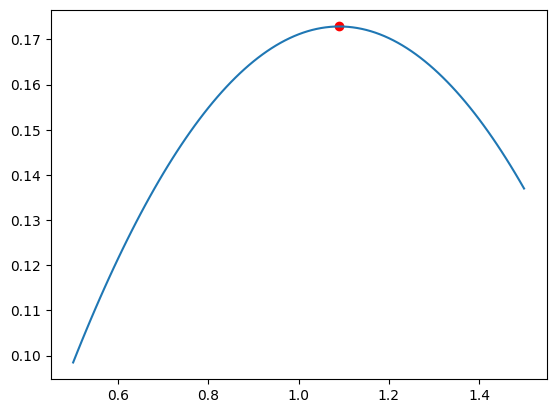

In [15]:
plt.plot(xhat, yhat)
plt.scatter(x_max, y_max, color="red");

In [16]:
np.random.seed(17)
aggregate_measurement, standard_error = run_experiment(15000, [x_max])
aggregate_measurement, standard_error

([0.1583811639290035], [0.008945771088795991])

In [17]:
aggregate_measurement[0] - 2 * standard_error[0], aggregate_measurement[
    0
] + 2 * standard_error[0]

(0.14048962175141153, 0.17627270610659548)

## Optimizing two or more continuous parameters

In [18]:
np.random.seed(17)
# parameters = design_ccd(thresholds=[0.5, 1.0, 1.5], order_sizes=[1, 1.5, 2])
parameters = design_ccd(thresholds=[0.8, 1, 1.2], order_sizes=[2.0, 2.5, 3.0, 3.5])
aggregate_measurements, standard_errors = run_experiment_2D(15000, parameters)
# parameters, aggregate_measurements, standard_errors

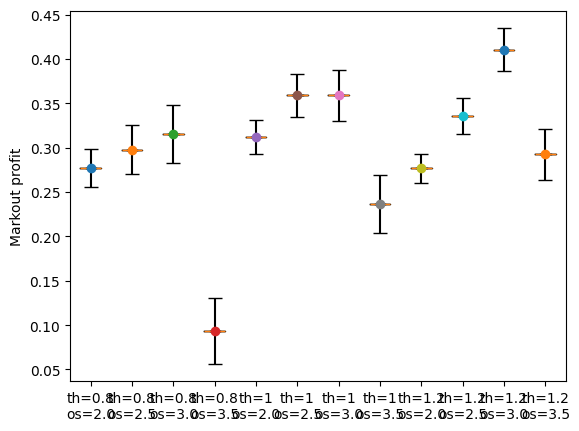

In [19]:
_fig, ax = plt.subplots()
ax.boxplot(
    np.array(aggregate_measurements).reshape(1, -1),
    positions=range(len(aggregate_measurements)),
)
# Add standard error bars
for i, (x, y, serr) in enumerate(
    zip(range(len(aggregate_measurements)), aggregate_measurements, standard_errors)
):
    ax.errorbar(x, y, yerr=serr, fmt="o", capsize=5, ecolor="black")

ax.set_xticklabels(["th={}\nos={}".format(*p) for p in parameters])
ax.set_ylabel("Markout profit");

In [20]:
p = LinearRegression().fit(
    PolynomialFeatures(degree=2).fit_transform(parameters),
    aggregate_measurements,
)
p.coef_

array([ 0.        ,  0.76655867,  0.71015834, -0.73040861,  0.32774051,
       -0.19642281])

In [21]:
p.predict(
    PolynomialFeatures(degree=2).fit_transform(parameters)
), aggregate_measurements

(array([0.27791466, 0.32213871, 0.26815135, 0.11595259, 0.2993755 ,
        0.3763736 , 0.3551603 , 0.23573558, 0.26240365, 0.3721758 ,
        0.38373655, 0.29708589]),
 [0.27708940099281754,
  0.29784893520006794,
  0.31588886931844135,
  0.09333010788066991,
  0.311876398646593,
  0.35901735287078407,
  0.3590057270728719,
  0.236745503170859,
  0.2767465777872881,
  0.3357661393728166,
  0.4102092885362126,
  0.29267988932693567])

In [22]:
def linear_regression_2D(parameters, aggregate_measurements):
    parameters = np.array(parameters)
    x0 = parameters[:, 0]
    x1 = parameters[:, 1]
    y = aggregate_measurements
    X = np.array([np.ones(len(y)), x0, x1, x0**2, x0 * x1, x1**2]).T
    beta = np.linalg.inv(X.T @ X) @ (X.T @ y)
    return beta

In [23]:
beta = linear_regression_2D(parameters, aggregate_measurements)
beta

array([-1.02688101,  0.76655867,  0.71015834, -0.73040861,  0.32774051,
       -0.19642281])

In [24]:
def interpolate_2D(parameters, beta):
    parameters = np.array(parameters)
    x0_values = np.arange(parameters[:, 0].min(), parameters[:, 0].max() + 1e-6, 0.01)
    x1_values = np.arange(parameters[:, 1].min(), parameters[:, 1].max() + 1e-6, 0.01)
    x0hat_2d, x1hat_2d = np.meshgrid(x0_values, x1_values)
    x0hat = x0hat_2d.flatten()
    x1hat = x1hat_2d.flatten()
    XHat = np.array(
        [np.ones(len(x0hat)), x0hat, x1hat, x0hat**2, x0hat * x1hat, x1hat**2]
    ).T
    yhat = XHat @ beta
    yhat_2d = np.reshape(yhat, (len(x1_values), len(x0_values)))
    return x0hat_2d, x1hat_2d, yhat_2d

In [25]:
def optimize_2D(parameters, beta):
    x0hat, x1hat, yhat = interpolate_2D(parameters, beta)
    i = np.where(yhat == yhat.max())
    return x0hat[i][0], x1hat[i][0], yhat[i][0]
    # x, y = np.unravel_index(np.argmax(yhat), yhat.shape)
    # i = ([x], [y])
    # return x0hat[i][0], x1hat[i][0], yhat[i][0]

In [26]:
np.random.seed(17)
beta = linear_regression_2D(parameters, aggregate_measurements)
threshold_opt, order_size_opt, estimated_max_profit = optimize_2D(parameters, beta)
threshold_opt, order_size_opt, estimated_max_profit

(1.1400000000000003, 2.759999999999984, 0.39272619450695345)

In [27]:
x, y = np.meshgrid([1, 2, 3], [4, 5, 6])
x, y, x.flatten(), y.flatten()

(array([[1, 2, 3],
        [1, 2, 3],
        [1, 2, 3]]),
 array([[4, 4, 4],
        [5, 5, 5],
        [6, 6, 6]]),
 array([1, 2, 3, 1, 2, 3, 1, 2, 3]),
 array([4, 4, 4, 5, 5, 5, 6, 6, 6]))

In [28]:
import itertools

# Note that the x and y is inversed
y, x = list(zip(*itertools.product([4, 5, 6], [1, 2, 3])))
y, x

((4, 4, 4, 5, 5, 5, 6, 6, 6), (1, 2, 3, 1, 2, 3, 1, 2, 3))

In [29]:
parameters = np.array(parameters)
x0_values = np.arange(parameters[:, 0].min(), parameters[:, 0].max() + 1e-6, 0.01)
x1_values = np.arange(parameters[:, 1].min(), parameters[:, 1].max() + 1e-6, 0.01)
# x = np.array(list(itertools.product(x0_values, x1_values)))
x0hat_2d, x1hat_2d = np.meshgrid(x0_values, x1_values)
x0hat = x0hat_2d.flatten()
x1hat = x1hat_2d.flatten()
x = list(zip(x0hat, x1hat))
y = p.predict(PolynomialFeatures(degree=2).fit_transform(x))

i = y.argmax()
print(x[i], y[i])

(1.1400000000000003, 2.759999999999984) 0.3927261945067131


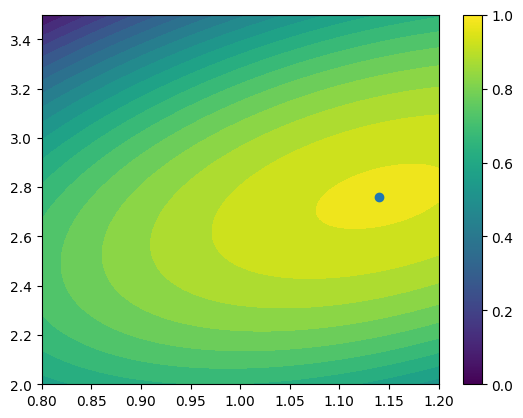

In [34]:
plt.contourf(x0_values, x1_values, y.reshape(-1, x0_values.shape[0]), levels=20)
plt.scatter(*x[i])
plt.colorbar();

In [31]:
aggregate_measurement, standard_error = run_experiment_2D(
    15000, parameters=[(threshold_opt, order_size_opt)]
)
aggregate_measurement, standard_error

([0.37001384966623435], [0.023458944375782362])

In [32]:
aggregate_measurement[0] - 2 * standard_error[0], aggregate_measurement[
    0
] + 2 * standard_error[0]

(0.32309596091466963, 0.41693173841779907)

In [36]:
from scipy.optimize import minimize

In [55]:
def objective(args):
    # The negative is to minimize the value, so we are finding the max values.
    return -p.predict(PolynomialFeatures(degree=2).fit_transform(args.reshape(-1, 2)))


minimize(objective, (0, 0))

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: -0.39273874534807307
        x: [ 1.145e+00  2.763e+00]
      nit: 5
      jac: [ 6.557e-07  2.965e-06]
 hess_inv: [[ 8.385e-01  6.888e-01]
            [ 6.888e-01  3.080e+00]]
     nfev: 18
     njev: 6

In [4]:
import numpy as np
from skopt import gp_minimize


def f(x):
    threshold, order_size = x
    return markout_profit_2D(threshold, order_size)


res = gp_minimize(f, [(0.8, 1.2), (2.0, 4.0)])
res

          fun: -15.877798248051867
            x: [0.9169705384277906, 3.6323398419933977]
    func_vals: [ 0.000e+00  0.000e+00 ...  0.000e+00 -5.832e+00]
      x_iters: [[0.9554047435470472, 2.713037349595759], [0.808207066479466, 3.983614621916495], [0.9746846148334046, 3.268154609996426], [0.9236504347757156, 2.116419207320988], [0.9483294464730802, 3.31565234865968], [0.8864964945564563, 3.879851038283865], [0.9016084673397688, 2.5213513612660825], [1.0404081336673954, 3.085851467839118], [1.0127370049428732, 3.426348395928438], [1.048604742555415, 3.5061112706242943], [1.0180925010444823, 3.4341502283178906], [0.8712969770868741, 3.9317328378418077], [0.8869284600760208, 3.8783341301171905], [0.8912158408998976, 3.8633593898272336], [0.9252544821027229, 3.881568803255582], [1.1805467627879098, 3.469907540006979], [0.8832888369132977, 2.1084509872935624], [0.9177329609858532, 2.7596520704734417], [0.9167861199507926, 3.0166879029609355], [0.9130464094003774, 2.572234373857027], [0